In [1]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt

In [2]:
def calculateLevelAt(level, x, y, z):
    for ox in range(0,2):
        for oy in range(0,2):
            for oz in range(0,2):
                data[level][x, y, z] += data[level+1][2*x+ox, 2*y+oy, 2*z+oz]
vCalculateLevelAt = np.vectorize(calculateLevelAt, excluded=['level'], otypes=[])
def calculateLevel(level):
    x = np.array(range(0,2**level))
    y = np.array(range(0,2**level))
    z = np.array(range(0,2**level))
    X,Y,Z = np.meshgrid(x,y,z)
    vCalculateLevelAt(level, X.flatten(), Y.flatten(), Z.flatten())
    data[level] /= 8.0

def calculateErrorAt(level, x, y, z):
    sub = 0.0
    for ox in range(0,2):
        for oy in range(0,2):
            for oz in range(0,2):
                error[level][x, y, z] += np.abs(data[level][x,y,z] - data[level+1][2*x+ox, 2*y+oy, 2*z+oz])
                sub += error[level+1][2*x+ox, 2*y+oy, 2*z+oz] # sum lower errors
    error[level][x, y, z] += sub
vCalculateErrorAt = np.vectorize(calculateErrorAt, excluded=['level'], otypes=[])
def calculateError(level):
    x = np.array(range(0,2**level))
    y = np.array(range(0,2**level))
    z = np.array(range(0,2**level))
    X,Y,Z = np.meshgrid(x,y,z)
    vCalculateErrorAt(level, X.flatten(), Y.flatten(), Z.flatten())

In [3]:
level_count = 8
count = 2**(level_count-1)
all_coordinates = np.empty((0,3), dtype=np.float32)
all_density = np.empty((0), dtype=np.float32)
for i in range(0, 11):
    name = "snap_000." + str(i)
    f = h5py.File("dataset/tng50-3-0/" + name + ".hdf5")
    part = f['PartType0']
    all_density = np.concatenate((all_density, part['Density']), dtype=np.float32)
    all_coordinates = np.concatenate((all_coordinates, part['Coordinates']), dtype=np.float32)

In [24]:
for i in np.linspace(0, 7, 8):
    print(f"asdf{int(i):01d}test")

asdf0test
asdf1test
asdf2test
asdf3test
asdf4test
asdf5test
asdf6test
asdf7test


In [ ]:
for i in np.linspace(0, 15, 16):
    #if i < 4:
        #continue
    for j in np.linspace(0, 15, 16):
        for k in np.linspace(0, 15, 16):
            print(i, j, k, datetime.datetime.now())
            
            min = np.array([i * 35000.0/16.0, j * 35000.0/16.0, k * 35000.0/16.0], dtype=np.float32)
            max = np.array([(i+1.0) * 35000.0/16.0, (j+1.0) * 35000.0/16.0, (k+1.0) * 35000.0/16.0], dtype=np.float32)
            size = max - min
            
            indices = np.all((all_coordinates > min - size / 2.0) & (all_coordinates < max + size / 2.0), axis=1)
            coordinates = all_coordinates[indices]
            density = all_density[indices]
            
            (x, x_step) = np.linspace(min[0], max[0], count, retstep=True)
            (y, y_step) = np.linspace(min[1], max[1], count, retstep=True)
            (z, z_step) = np.linspace(min[2], max[2], count, retstep=True)
            X, Y, Z = np.meshgrid(x+0.5*x_step, y+0.5*y_step, z+0.5*z_step)
            
            linear = LinearNDInterpolator(coordinates, density, fill_value=0)
            
            lowest = linear(X, Y, Z)
            file = open(f"linear{int(i):02d}{int(j):02d}{int(k):02d}.bin", 'wb')
            file.write(lowest.astype(np.float32).tobytes())
            file.close()
            
            data = [np.zeros((2**level, 2**level, 2**level), dtype=np.float32) for level in range(0, level_count)]
            data[level_count-1] = lowest;
            
            
            for l in reversed(range(0, level_count-1)):
                calculateLevel(l)
            
            error = [np.zeros((2**level, 2**level, 2**level), dtype=np.float32) for level in range(0, level_count)]
            
            for l in reversed(range(0, level_count-1)):
                calculateError(l)

            file = open(f"layered{int(i):02d}{int(j):02d}{int(k):02d}.bin", 'wb')
            
            # depth
            level_count_to_write = np.array([level_count], dtype='uint32')
            file.write(level_count_to_write.tobytes())
            
            # cube bounds
            file.write(min.astype(np.float32).tobytes())
            file.write(max.astype(np.float32).tobytes())
            
            # scalar data
            for l in range(0, level_count):
                file.write(data[l].astype(np.float32).tobytes())
            
            # error
            # the final level doesn't need an error
            for l in range(0, level_count-1):
                file.write(error[l].astype(np.float32).tobytes())
            file.close()

0.0 0.0 0.0 2024-01-27 11:55:24.656725
0.0 0.0 1.0 2024-01-27 11:55:51.186136
0.0 0.0 2.0 2024-01-27 11:56:23.366950
0.0 0.0 3.0 2024-01-27 11:56:55.119752
0.0 0.0 4.0 2024-01-27 11:57:26.977843
0.0 0.0 5.0 2024-01-27 11:57:57.589433
0.0 0.0 6.0 2024-01-27 11:58:27.305156
0.0 0.0 7.0 2024-01-27 11:58:57.215953
0.0 0.0 8.0 2024-01-27 11:59:28.307354
0.0 0.0 9.0 2024-01-27 11:59:58.739731
0.0 0.0 10.0 2024-01-27 12:00:29.090059
0.0 0.0 11.0 2024-01-27 12:01:01.342023
0.0 0.0 12.0 2024-01-27 12:01:34.245548
0.0 0.0 13.0 2024-01-27 12:02:06.015396
0.0 0.0 14.0 2024-01-27 12:02:37.277786
0.0 0.0 15.0 2024-01-27 12:03:09.484233
0.0 1.0 0.0 2024-01-27 12:03:37.829161
0.0 1.0 1.0 2024-01-27 12:04:10.203632
0.0 1.0 2.0 2024-01-27 12:04:49.612961
0.0 1.0 3.0 2024-01-27 12:05:28.368776
0.0 1.0 4.0 2024-01-27 12:06:05.807173
0.0 1.0 5.0 2024-01-27 12:06:43.328194
0.0 1.0 6.0 2024-01-27 12:07:19.440244
0.0 1.0 7.0 2024-01-27 12:07:56.379365
0.0 1.0 8.0 2024-01-27 12:08:34.943477
0.0 1.0 9.0 2024-01

In [5]:
level_count = 9
count = 2**(level_count-1)
i = 1.0
j = 0.0
k = 0.0
min = np.array([i * 35000.0/4.0, j * 35000.0/4.0, k * 35000.0/4.0], dtype=np.float32)
max = np.array([(i+1.0) * 35000.0/4.0, (j+1.0) * 35000.0/4.0, (k+1.0) * 35000.0/4.0], dtype=np.float32)
size = max - min

coordinates = np.empty((0,3), dtype=np.float32)
density = np.empty((0), dtype=np.float32)
for i in range(0, 11):
    name = "snap_000." + str(i)
    f = h5py.File("dataset/tng50-4-0/" + name + ".hdf5")
    part = f['PartType0']
    density = np.concatenate((density, part['Density']), dtype=np.float32)
    coordinates = np.concatenate((coordinates, part['Coordinates']), dtype=np.float32)
indices = np.all((coordinates > min - size / 2.0) & (coordinates < max + size / 2.0), axis=1)
coordinates = coordinates[indices]
density = density[indices]
print(coordinates.shape)
print(density.shape)

(1370044, 3)
(1370044,)


In [6]:
(x, x_step) = np.linspace(min[0], max[0], count, retstep=True)
(y, y_step) = np.linspace(min[1], max[1], count, retstep=True)
(z, z_step) = np.linspace(min[2], max[2], count, retstep=True)
X, Y, Z = np.meshgrid(x+0.5*x_step, y+0.5*y_step, z+0.5*z_step)

In [22]:
X.flatten()[:513]

array([8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686275,
       8767.15686275, 8767.15686275, 8767.15686275, 8767.15686

In [21]:
Y.flatten()[:1024]

array([17.15686275, 17.15686275, 17.15686275, ..., 17.15686275,
       17.15686275, 17.15686275])

In [18]:
Z.flatten()[:512]

array([  17.15686275,   51.47058824,   85.78431373,  120.09803922,
        154.41176471,  188.7254902 ,  223.03921569,  257.35294118,
        291.66666667,  325.98039216,  360.29411765,  394.60784314,
        428.92156863,  463.23529412,  497.54901961,  531.8627451 ,
        566.17647059,  600.49019608,  634.80392157,  669.11764706,
        703.43137255,  737.74509804,  772.05882353,  806.37254902,
        840.68627451,  875.        ,  909.31372549,  943.62745098,
        977.94117647, 1012.25490196, 1046.56862745, 1080.88235294,
       1115.19607843, 1149.50980392, 1183.82352941, 1218.1372549 ,
       1252.45098039, 1286.76470588, 1321.07843137, 1355.39215686,
       1389.70588235, 1424.01960784, 1458.33333333, 1492.64705882,
       1526.96078431, 1561.2745098 , 1595.58823529, 1629.90196078,
       1664.21568627, 1698.52941176, 1732.84313725, 1767.15686275,
       1801.47058824, 1835.78431373, 1870.09803922, 1904.41176471,
       1938.7254902 , 1973.03921569, 2007.35294118, 2041.66666

# LINEAR

In [48]:
print(datetime.datetime.now())
linear = LinearNDInterpolator(coordinates, density, fill_value=0)
print(datetime.datetime.now())

2023-11-19 16:02:21.207992
2023-11-19 16:03:06.989075


In [49]:
print(datetime.datetime.now())
lowest = linear(X, Y, Z)
print(datetime.datetime.now())
file = open('linear256.bin', 'wb')
file.write(lowest.astype(np.float32).tobytes())
file.close()

2023-11-19 16:03:07.007400
2023-11-19 16:05:55.548955


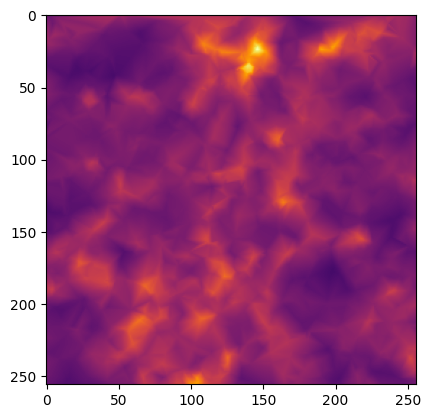

In [50]:
plt.imshow(lowest[:,:,0], cmap='inferno')

# Nearest

In [18]:
print(datetime.datetime.now())
nearest = NearestNDInterpolator(coordinates, density)
print(datetime.datetime.now())

2023-11-13 15:56:02.909709
2023-11-13 15:56:17.298406


In [19]:
print(datetime.datetime.now())
lowest = nearest(X, Y, Z).astype(np.float32)
print(datetime.datetime.now())
file = open('nearest512.bin', 'wb')
file.write(lowest.tobytes())
file.close()

2023-11-13 15:56:17.316064
2023-11-13 15:56:38.344743


# Processing

In [52]:
# lowest = np.fromfile('dataset/tng50-4-0/linear512.bin', dtype=np.float32).reshape((count, count, count)) # load from file

In [2]:
data = [np.zeros((2**level, 2**level, 2**level), dtype=np.float32) for level in range(0, level_count)]
data[level_count-1] = lowest;
def calculateLevelAt(level, x, y, z):
    for ox in range(0,2):
        for oy in range(0,2):
            for oz in range(0,2):
                data[level][x, y, z] += data[level+1][2*x+ox, 2*y+oy, 2*z+oz]
vCalculateLevelAt = np.vectorize(calculateLevelAt, excluded=['level'], otypes=[])
def calculateLevel(level):
    x = np.array(range(0,2**level))
    y = np.array(range(0,2**level))
    z = np.array(range(0,2**level))
    X,Y,Z = np.meshgrid(x,y,z)
    vCalculateLevelAt(level, X.flatten(), Y.flatten(), Z.flatten())
    data[level] /= 8.0

NameError: name 'level_count' is not defined

In [3]:
print(datetime.datetime.now())
for i in reversed(range(0, level_count-1)):
    calculateLevel(i)
print(datetime.datetime.now())

NameError: name 'datetime' is not defined

In [53]:
print(np.min(np.array([np.min(data[i]) for i in range(0, len(data))])))
print(np.max(np.array([np.max(data[i]) for i in range(0, len(data))])))

0.0
6.6924957608225024e-09


In [54]:
error = [np.zeros((2**level, 2**level, 2**level), dtype=np.float32) for level in range(0, level_count)]
def calculateErrorAt(level, x, y, z):
    sub = 0.0
    for ox in range(0,2):
        for oy in range(0,2):
            for oz in range(0,2):
                error[level][x, y, z] += np.abs(data[level][x,y,z] - data[level+1][2*x+ox, 2*y+oy, 2*z+oz])
                sub += error[level+1][2*x+ox, 2*y+oy, 2*z+oz] # sum lower errors
    error[level][x, y, z] += sub
    #error[level][x, y, z] += sub * 0.5  # optional divide after lower errors
vCalculateErrorAt = np.vectorize(calculateErrorAt, excluded=['level'], otypes=[])
def calculateError(level):
    x = np.array(range(0,2**level))
    y = np.array(range(0,2**level))
    z = np.array(range(0,2**level))
    X,Y,Z = np.meshgrid(x,y,z)
    vCalculateErrorAt(level, X.flatten(), Y.flatten(), Z.flatten())

In [1]:
x

NameError: name 'x' is not defined

In [55]:
print(datetime.datetime.now())
for i in reversed(range(0, level_count-1)):
    calculateError(i)
print(datetime.datetime.now())

2023-11-19 16:06:09.382028
2023-11-19 16:06:48.379274


In [56]:
file = open('layered256.bin', 'wb')

# depth
level_count_to_write = np.array([level_count], dtype='uint32')
file.write(level_count_to_write.tobytes())

# cube bounds
file.write(min.astype(np.float32).tobytes())
file.write(max.astype(np.float32).tobytes())

# scalar data
for i in range(0, level_count):
    file.write(data[i].astype(np.float32).tobytes())

# error
# the final level doesn't need an error
for i in range(0, level_count-1):
    file.write(error[i].astype(np.float32).tobytes())
file.close()

# Priority
This does not work well with distance scaling so don't use this

In [57]:
priority = [np.empty((2**level, 2**level, 2**level), dtype=np.float32) for level in range(0, level_count)]
flattened_error = np.concatenate([x.flatten() for x in error])
flattened_priority = np.argsort(-flattened_error)
print(flattened_priority[0]) # should be 0
offset = 0
for i in range(0, level_count):
    level_size = (2**i)**3
    priority[i] = np.reshape(flattened_priority[offset:(offset+level_size)], priority[i].shape)
    offset += level_size

0


In [61]:
file = open('layered512.bin', 'wb')
level_count_to_write = np.array([level_count], dtype='uint32')
file.write(level_count_to_write.tobytes())
for i in range(0, level_count):
    file.write(data[i].astype(np.float32).tobytes())
# the final level doesn't need a priority
for i in range(0, level_count-1):
    file.write(priority[i].astype('uint32').tobytes())
# the final level doesn't need an error
for i in range(0, level_count-1):
    file.write(error[i].astype(np.float32).tobytes())
file.close()

In [63]:
np.max(error[0])

0.0022813566

# Constructing the octree
max_depth - min_depth = 1 for the octree, and only 2 million of 14 million possible leaves don't have maximum depth.
it is not worth it to construct the octree. We would also need extra positional data which would make it worse than the full array.

In [171]:
level_children = [np.empty((2**level)**3, dtype='uint32') for level in range(0, level_count)]
level_positions = [np.empty(((2**level)**3, 3), dtype=np.float32) for level in range(0, level_count)]
level_sizes = [np.full((2**level)**3, level_count - (level+1), dtype=np.float32) for level in range(0, level_count)]
level_values = [np.empty((2**level)**3, dtype=np.float32) for level in range(0, level_count)]
level_counts = [0 for level in range(0, level_count)]

In [172]:
def filterLevelAt(level, x, y, z):
    offset = np.arange(0,2)
    equal = np.all(np.abs(data[level][x+offset, y+offset, z+offset] - data[level][x, y, z]) < np.abs(data[level][x,y,z] * 1e-4))
    
    #if not equal: 
    #    for ox in range(0,2):
    #        for oy in range(0,2):
    #            for oz in range(0,2):
    #                level_children[level][level_counts[level]] = level_counts[level+1]
    #                level_counts[level] += 1
vFilterLevelAt = np.vectorize(filterLevelAt, excluded=['level'], otypes=[])

def filterLevel(level):
    if level == 1:
        vFilterLevelAt(level, np.array([0]), np.array([0]), np.array([0]))
        return
    count = 2**(level-2)
    # Traversal order so that cells belonging to the same octree parent are adjacent in memory.
    # This way, we only have to save the index of the first child.
    x = np.tile(np.tile([0,1,0,1,0,1,0,1], count) + np.repeat(2*np.arange(0, count), 8), count * count)
    y = np.tile(np.tile([0,0,1,1,0,0,1,1], count * count) + np.repeat(2*np.arange(0, count), 8*count), count)
    z = np.tile([0,0,0,0,1,1,1,1], count * count * count) + np.repeat(2*np.arange(0, count), 8*count*count)
    vFilterLevelAt(level, x, y, z)

In [173]:
np.tile(np.tile([0,1,0,1,0,1,0,1], 2) + np.repeat(2*np.arange(0, 2), 8), 4).shape

(64,)

In [174]:
(1 + np.arange(0,2)) == (3 - np.arange(0,2))

array([False,  True])

In [175]:
print(datetime.datetime.now())
for i in range(1, level_count):
    filterLevel(i)
    print("Count in level " + str(i) + ": " + str(level_counts[i]) + "/" + str((2**i)**3))
print(datetime.datetime.now())

2023-11-13 23:02:40.226536
Count in level 1: 0/8
Count in level 2: 0/64
Count in level 3: 0/512
Count in level 4: 0/4096
Count in level 5: 0/32768
Count in level 6: 0/262144
Count in level 7: 0/2097152


KeyboardInterrupt: 

In [ ]:
levels = [np.empty((2**level)**3, dtype='uint32') for level in range(0, level_count)]
level_counts = [0 for level in range(0, level_count)]

In [112]:
def filterLevelAt(level, x, y, z):
    equal = True
    for ox in range(0,2):
        for oy in range(0,2):
            for oz in range(0,2):
                #equal = equal and (data[level][x+ox, y+oy, z+oz] == data[level][x, y, z])
                equal = equal and (np.abs(data[level][x+ox, y+oy, z+oz] - data[level][x, y, z]) < np.abs(data[level][x,y,z] * 1e-3))
    level_counts[level] += (1 - equal) * 8
    if not equal: 
        for ox in range(0,2):
            for oy in range(0,2):
                for oz in range(0,2):
                    levels[level][level_counts[level]] = np.ravel_multi_index((x+ox,y+oy,z+oz), data[level].shape)
                    level_counts[level] += 1
vFilterLevelAt = np.vectorize(filterLevelAt, excluded=['level'], otypes=[])
def filterLevel(level):
    x = np.array([2 * i for i in range(0, 2**(level-1))])
    y = np.array([2 * i for i in range(0, 2**(level-1))])
    z = np.array([2 * i for i in range(0, 2**(level-1))])
    X, Y, Z = np.meshgrid(x,y,z)
    vFilterLevelAt(level, X.flatten(), Y.flatten(), Z.flatten())

# Slice visualization

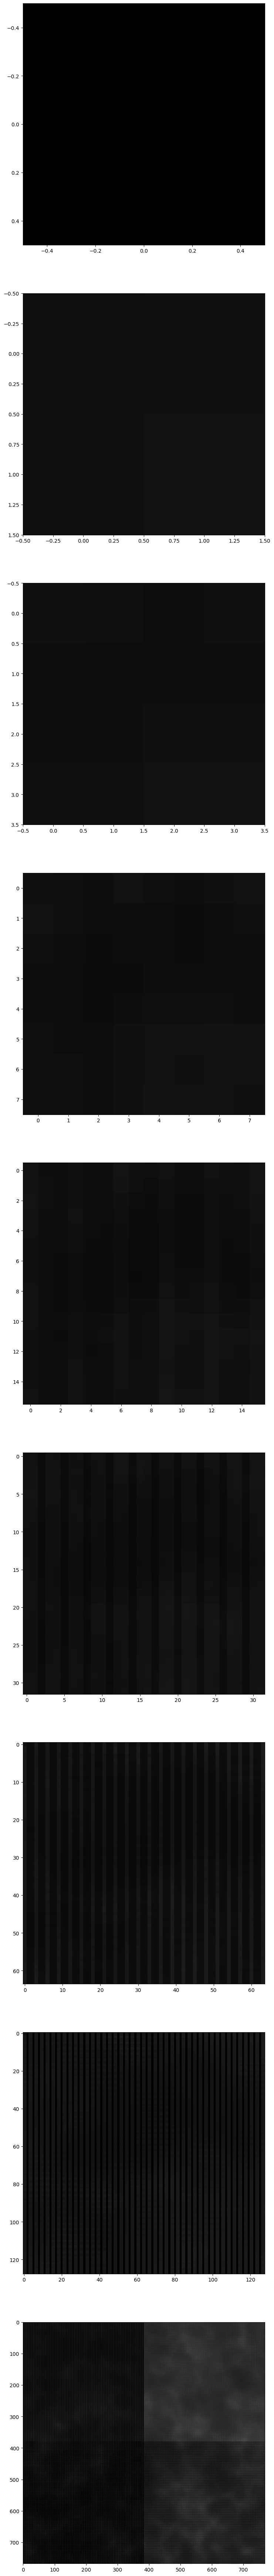

In [19]:
min = np.min(np.array([np.min(data[i]) for i in range(0, level_count)]))
max = np.max(np.array([np.max(data[i]) for i in range(0, level_count)]))
fig, ax = plt.subplots(level_count)
fig.set_size_inches(10, level_count * 10, forward=True)
for i in range(0, level_count):
    ax[i].imshow(data[i][:,:,0], vmin=min, vmax=max, cmap='gray')

0 0.0022813566


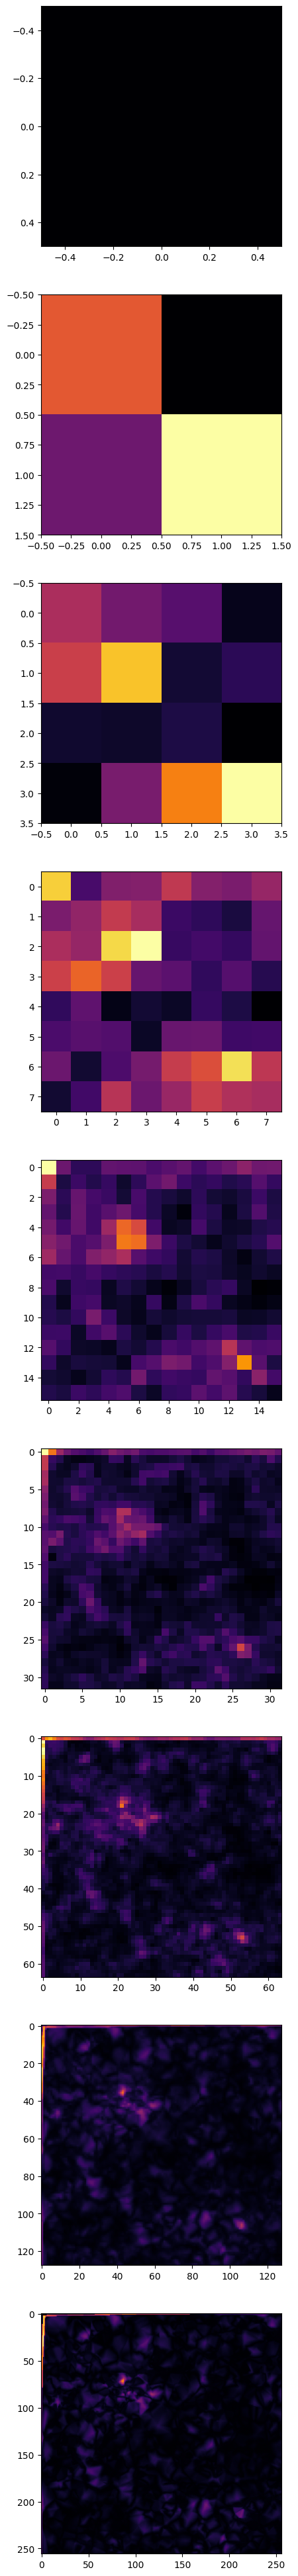

In [60]:
min_error = 0
max_error = np.max(np.array([np.max(error[i]) for i in range(0, level_count-1)]))
print(min_error, max_error)
fig, ax = plt.subplots(level_count-1)
fig.set_size_inches(5, level_count * 5, forward=True)
for i in range(0, level_count-1):
    ax[i].imshow(error[i][:,:,0], cmap='inferno')
    #ax[i].imshow(error[i][:,:,0], norm='log', vmin = min_error, vmax = max_error, cmap='inferno')